## 1 ere question

In [3]:
import pandas as pd
import urllib
import zipfile
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt  # for plots
from matplotlib import rc
import seaborn as sns
from os import mkdir, path
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from math import cos, sin, pi, sqrt
from statsmodels.nonparametric.kde import KDEUnivariate
from scipy.linalg import toeplitz
from numpy.linalg import eigh
from sklearn import linear_model, datasets
from sklearn import preprocessing as pr
from multiprocessing import Process


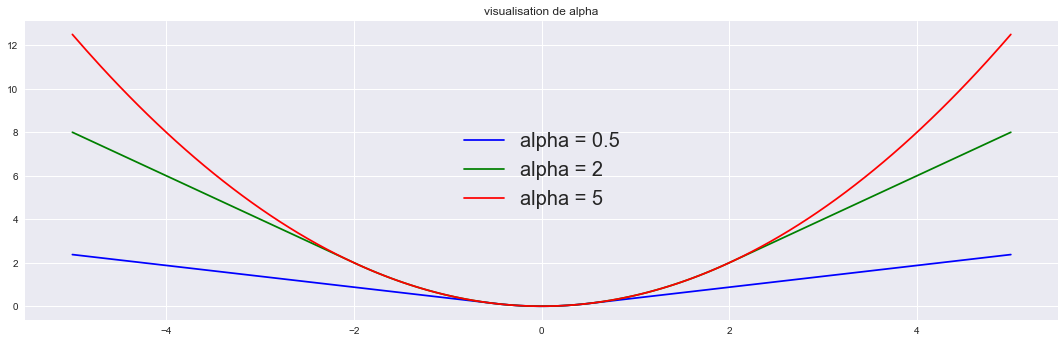

In [2]:
# Afficchage de palpha entre -5 et 5


xmin = -5
xmax = 5
%matplotlib inline
plt.style.use('seaborn')
plt.figure(figsize=(18.5, 5.5))


def palphavect(x, alpha):
    y = np.zeros(x.shape)
    if alpha == 0:
        y = np.abs(x)
    else:
        y[np.abs(x) <= alpha] = x[np.abs(x) <= alpha]**2 / 2
        y[np.abs(x) > alpha] = np.abs(
            x[np.abs(x) > alpha]) * alpha - alpha**2 / 2
    return y


def palpha(x, alpha):
    if abs(x) <= alpha:
        res = x**2 / 2
    else:
        res = alpha * abs(x) - alpha**2 / 2
    return res

#x_grid = list(np.linspace(xmin, xmax, 200))
x_grid = np.linspace(xmin, xmax, 200).reshape(-1, 1)
#yalpha_0_5 = list(map(lambda x: palpha(x, 0.5), x_grid))
yalpha_0_5 = palphavect(x_grid, 0.5)
#yalpha_2 = list(map(lambda x: palpha(x, 2), x_grid))
yalpha_2 = palphavect(x_grid, 2)
#yalpha_5 = list(map(lambda x: palpha(x, 5), x_grid))
yalpha_5 = palphavect(x_grid, 5)

## alpha =0.5
plt.plot(x_grid, yalpha_0_5, label='alpha = 0.5', color='blue')
plt.plot(x_grid, yalpha_2, label='alpha = 2', color='green')
plt.plot(x_grid, yalpha_5, label='alpha = 5', color='red')
plt.title("visualisation de alpha")
plt.legend(fontsize=20, loc=10)
plt.show()

## 2 generation des tuples de (xi,yi)

In [3]:
# génértion des xi vecteur de dimension 2


def computeMCO(theta, theta0, x, epsilon):
    res = theta0 + np.dot(x, theta) + epsilon
    return res

# génération des vecteurs aléatoires à l'aide de numpy
genVect = np.random.rand(100, 2)
genEpsilon = np.random.normal(0, 1, 100).reshape(-1, 1)
theta0 = np.ones((100, 1))
theta = np.array([1, 1]).reshape(-1, 1)
y = computeMCO(theta, theta0, genVect, genEpsilon)

## 3 eme question

In [4]:
from scipy.optimize import minimize
# calcul de ThetaAplha pour alpha = 2


def thetaAlpha(alpha, x, y, n, d):
    init = np.zeros((d, 1))
    f = lambda theta: sum([palpha((y[i] - theta[0] - np.dot(x[::, i].T,
                                                            np.array([[theta[1]], [theta[2]]]))), alpha) for i in range(n)])
    res = minimize(f, init, method='Nelder-Mead', tol=1e-5)
    return res


def thetaAlphaVect(alpha, x, y, n, d):
    if d == 2:
        init = 0
        f = lambda theta: np.sum(palphavect(y - np.dot(x, theta), alpha))
        res = minimize(f, init, method='Nelder-Mead', tol=1e-5)
    else:
        init = np.zeros((d, 1))
        f = lambda theta: np.sum(palphavect(
            y - theta[0] - np.dot(x, np.array([[theta[1]], [theta[2]]])), alpha))
        res = minimize(f, init, method='Nelder-Mead', tol=1e-5)
    return res


res = thetaAlphaVect(2, genVect, y, 100, 3)
ThetalphaChap = res.x
print("le résultat est: ", res.x)

le résultat est:  [ 0.65866698  1.40369081  1.12701517]


## 4eme question

In [5]:
# bootstrap des résidus


def TirageEpsilon(x):
    tirage = np.random.randint(0, x.shape[0], x.shape[0])
    return x[tirage]


def bootStrap(alpha, theta, theta0, x, Epsilon, n):
    res = []
    for i in range(0, n):
        epsilonboot = TirageEpsilon(Epsilon)
        yboot = computeMCO(theta, theta0, x, epsilonboot)
        res.append(thetaAlphaVect(alpha, x, yboot, x.shape[
                   0], theta.shape[0] + 1).x.tolist())
    return res
print("le résultat est: ", bootStrap(2, theta, theta0, genVect, genEpsilon, 1))

le résultat est:  [[0.7509268710676791, 1.2147619284714193, 0.9339807149899416]]


## 5 eme question

In [6]:
# Bootstrap pour 200 itéartions

res = bootStrap(2, theta, theta0, genVect, genEpsilon, 200)

In [1]:
# Variance
Varboot = np.cov(np.asarray(res).reshape(200, 3).T)
print("la matrice de covariance est\n ", Varboot)
#tethaChap = np.asarray([1, 1, 1])
# Biais
Bboot = np.mean((res - ThetalphaChap), axis=0)
print("Le biais est :", Bboot)

# estimateur de l'erreur quadratique de la moyenne associée
ThetaNormEuclid = np.mean(res, axis=0)
Risque = np.linalg.norm(ThetalphaChap - ThetaNormEuclid)**2 + \
    1 / 200 * np.linalg.norm((res - ThetaNormEuclid))**2
print("Le Risque est : ", Risque)

NameError: name 'np' is not defined

## 6 eme question

In [27]:
# But minimiser le risque en fonction de alpha
x_gridalpha = list(np.linspace(0, 10, 20))
print(x_gridalpha)

# On repete 20 fois la procèdure précédente pour des alpha différent


def EqmBoot(alpha, n, theta, theta0, genVect, y, genEpsilon):
    ThetalphaChap = thetaAlphaVect(
        alpha, genVect, y, n, genVect.shape[1] + 1).x
    res = bootStrap(alpha, theta, theta0, genVect, genEpsilon, n)
    ThetaNormEuclid = np.mean(res, axis=0)
    Risque = np.linalg.norm(ThetalphaChap - ThetaNormEuclid)**2 + \
        1 / n * np.linalg.norm((res - ThetaNormEuclid))**2
    return Risque

AlphaGrid = list(map(lambda x: EqmBoot(x,
                                       200, theta, theta0, genVect, y, genEpsilon), x_gridalpha))



[0.0, 0.52631578947368418, 1.0526315789473684, 1.5789473684210527, 2.1052631578947367, 2.6315789473684208, 3.1578947368421053, 3.6842105263157894, 4.2105263157894735, 4.7368421052631575, 5.2631578947368416, 5.7894736842105257, 6.3157894736842106, 6.8421052631578947, 7.3684210526315788, 7.8947368421052628, 8.4210526315789469, 8.9473684210526319, 9.473684210526315, 10.0]


NameError: name 'theta' is not defined

le résultat est: 
 [0.73780597378270474, 0.65269938087688228, 0.56346143623742473, 0.44892228313695381, 0.49691649665970117, 0.52466958647539796, 0.4518090015309974, 0.50056598255114793, 0.48722991730908227, 0.42885918500232134, 0.46472134295478573, 0.5225380450458863, 0.49522960240402181, 0.484266398404057, 0.52775789765106251, 0.51645424428455866, 0.46882904839365858, 0.45650956524810521, 0.52390732065762968, 0.53121087906295061]


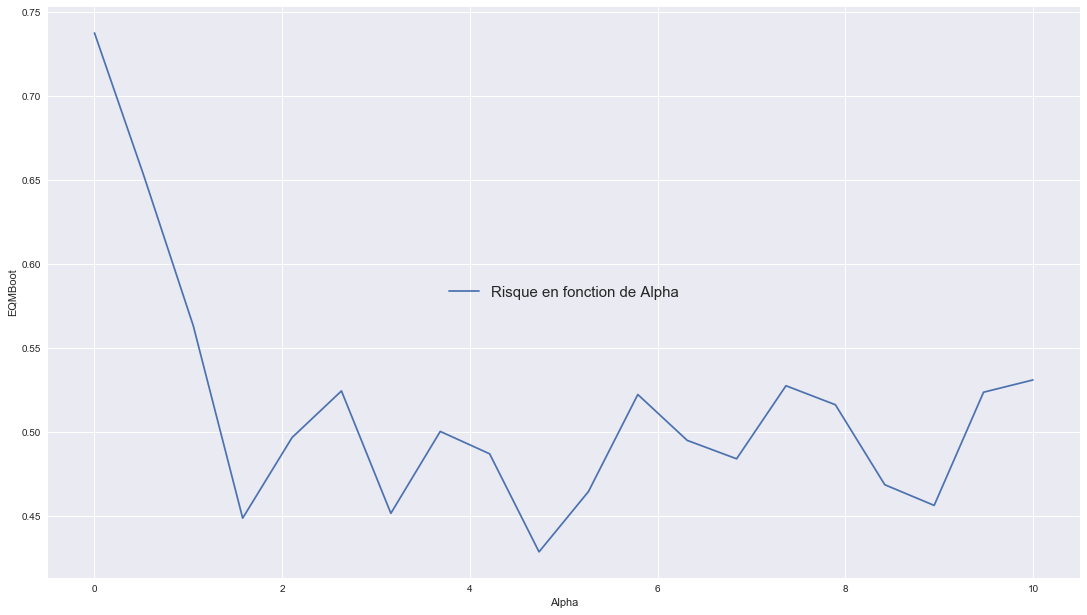

In [9]:
print("le résultat est: \n", AlphaGrid)
plt.style.use('seaborn')
plt.figure(figsize=(18.5, 10.5))
plt.plot(x_gridalpha, AlphaGrid, label="Risque en fonction de Alpha")
plt.legend(fontsize=15, loc=10)
plt.xlabel("Alpha")
plt.ylabel("EQMBoot")
plt.show()

 On peut remarquer le que minimum pour l'échantillon généré est atteint entre aplha [4,5]. on remarque que la distribution normale des x fait que notre EQMBoot converge.

## 7 eme question

In [10]:
# On change à présent la distribution
# génération des vecteurs aléatoires à l'aide de numpy

genEpsilonCauchy = np.random.standard_cauchy(100).reshape(-1, 1)
theta0 = np.ones((100, 1))
theta = np.array([1, 1]).reshape(-1, 1)
ycauchy = computeMCO(theta, theta0, genVect, genEpsilonCauchy)

AlphaGridCauchy = list(map(lambda x: EqmBoot(x,
                                             200, theta, theta0, genVect, ycauchy, genEpsilonCauchy), x_gridalpha))

le résultat est: 
 [2.4559008227496788, 2.0472738995275717, 2.2867833389908965, 2.0392196503126976, 2.2237133730076621, 2.5417335639037586, 3.0145645796186802, 2.7380959025664451, 3.0187441041010499, 3.4655386073291643, 4.0312513478969541, 3.8319561776743805, 3.7586022342493335, 4.4721121486841522, 5.0934653690742406, 5.8626478746043382, 6.3292866553856157, 5.821856839601983, 6.8034368416162483, 7.6531359068809222]


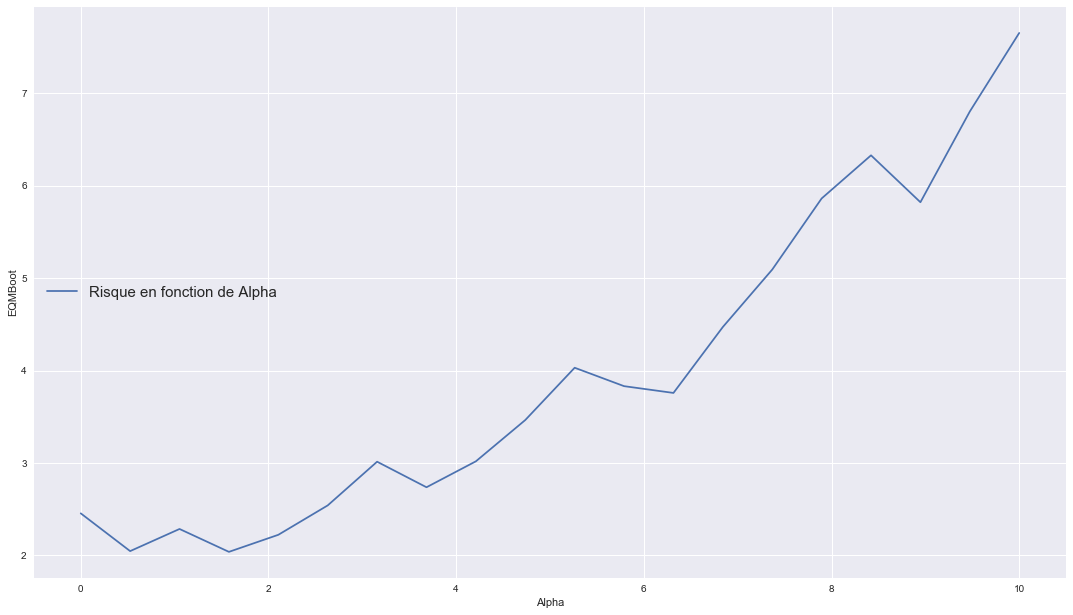

In [11]:
print("le résultat est: \n", AlphaGridCauchy)
plt.style.use('seaborn')
plt.figure(figsize=(18.5, 10.5))
plt.plot(x_gridalpha, AlphaGridCauchy, label="Risque en fonction de Alpha")
plt.legend(fontsize=15, loc=6)
plt.xlabel("Alpha")
plt.ylabel("EQMBoot")
plt.show()

On remarque que la distribution de Cauchy de nos x fait diverger notre EqmBoot, on peut remarquer que le minimum est atteint entre [0,2]

## 8 eme question

In [14]:
# charger la base diabest de scikit learn
diabetes = datasets.load_diabetes()
Xdiabetes = diabetes.data
Ydiabetes = diabetes.target.reshape(-1, 1)
# On normalise
Xtraindiab = Xdiabetes[:, 3]
Xtraindiab = Xtraindiab.reshape(-1, 1)
Xtraindiab = pr.scale(Xtraindiab)
# On applique la MCO
lr = linear_model.LinearRegression(fit_intercept=False)
DiabMod = lr.fit(Xtraindiab, Ydiabetes)

# On calcule nos epsilons
EpsilonDiab = Ydiabetes - DiabMod.predict(Xtraindiab)
EpsilonDiab = EpsilonDiab.reshape(-1, 1)


# d'après les deux courbes il serait judicieux de réduire notre intervalle
# à [4,6]

alphagridiabetes = np.linspace(4, 6, 20)
ThetaDiab = lr.coef_[0]
T0 = np.zeros((442, 1))
computeMCO(ThetaDiab, T0, Xtraindiab, EpsilonDiab)

array([[ 151.        ,  116.54931718,  131.31389553, ...,  147.7189826 ,
         136.23542165,   77.17710824],
       [ 109.45068282,   75.        ,   89.76457835, ...,  106.16966542,
          94.68610447,   35.62779106],
       [ 160.68610447,  126.23542165,  141.        , ...,  157.40508707,
         145.92152612,   86.86321271],
       ..., 
       [ 135.2810174 ,  100.83033458,  115.59491293, ...,  132.        ,
         120.51643905,   61.45812564],
       [ 234.76457835,  200.31389553,  215.07847388, ...,  231.48356095,
         220.        ,  160.94168659],
       [ 130.82289176,   96.37220894,  111.13678729, ...,  127.54187436,
         116.05831341,   57.        ]])

In [15]:
AlphaGridDiabetes = list(map(lambda x: EqmBoot(x,
                                               200, ThetaDiab, T0, Xtraindiab, Ydiabetes, EpsilonDiab), alphagridiabetes))

le résultat est: 
 [1131.0648760863603, 1147.9949132666918, 1142.0740703211156, 1117.0568837036849, 1137.2726611813416, 1146.3722931082034, 1136.5735989070149, 1141.6241349512118, 1140.0335607713939, 1157.2518376957835, 1131.8373418004599, 1141.7715337336015, 1138.7528634609387, 1118.7653946679366, 1135.0746509702092, 1137.2528328077856, 1143.5217506114461, 1130.8022624530963, 1140.1107913231447, 1130.4892672313792]


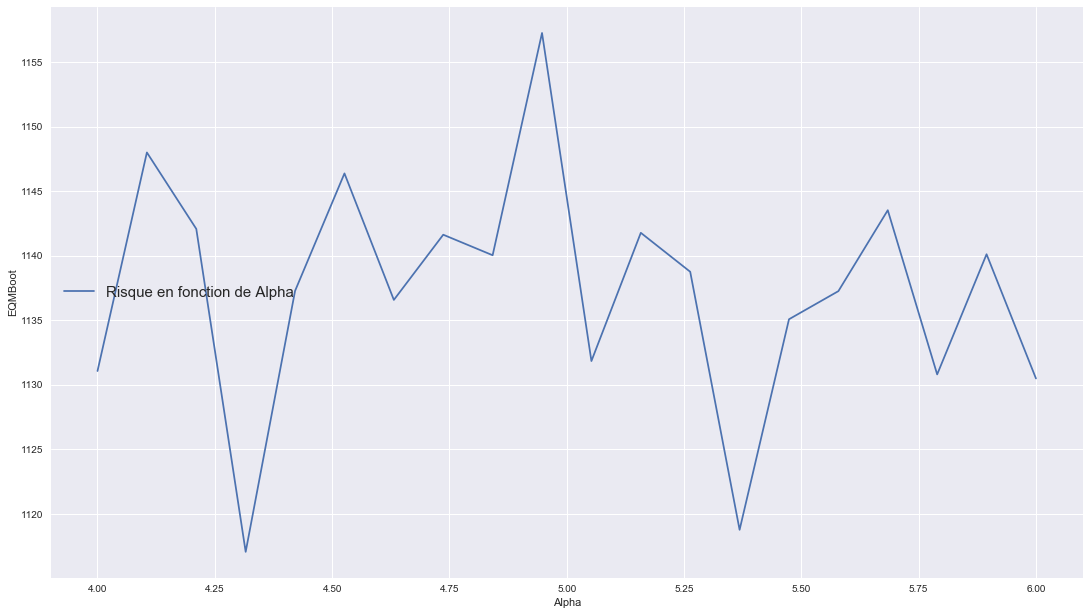

In [16]:
print("le résultat est: \n", AlphaGridDiabetes)
plt.style.use('seaborn')
plt.figure(figsize=(18.5, 10.5))
plt.plot(alphagridiabetes, AlphaGridDiabetes,
         label="Risque en fonction de Alpha")
plt.legend(fontsize=15, loc=6)
plt.xlabel("Alpha")
plt.ylabel("EQMBoot")
plt.show()

On voit que que EQMBoot est très elevé et atteint un minimum en 4.3.  En limitant le tirage et agrandissant la fenetre pour les alphas on obtient.

In [17]:
alphagridiabetes_2 = np.linspace(0, 10, 20)
AlphaGridDiabetes_2 = list(map(lambda x: EqmBoot(x,
                                                 20, ThetaDiab, T0, Xtraindiab, Ydiabetes, EpsilonDiab), alphagridiabetes_2))

le résultat est: 
 [1175.594998872175, 1134.1652925473174, 1104.4348443496606, 1154.6979093406774, 1174.4648713456122, 1113.8209278340235, 1160.7688978845254, 1122.2155071526035, 1127.456851383841, 1128.6886968570345, 1103.3367647758334, 1130.5667442625036, 1177.0149879267121, 1144.218197108893, 1177.2212981931675, 1160.2455375518102, 1141.1505520939611, 1150.199168669245, 1124.4453540631373, 1172.7371160710977]


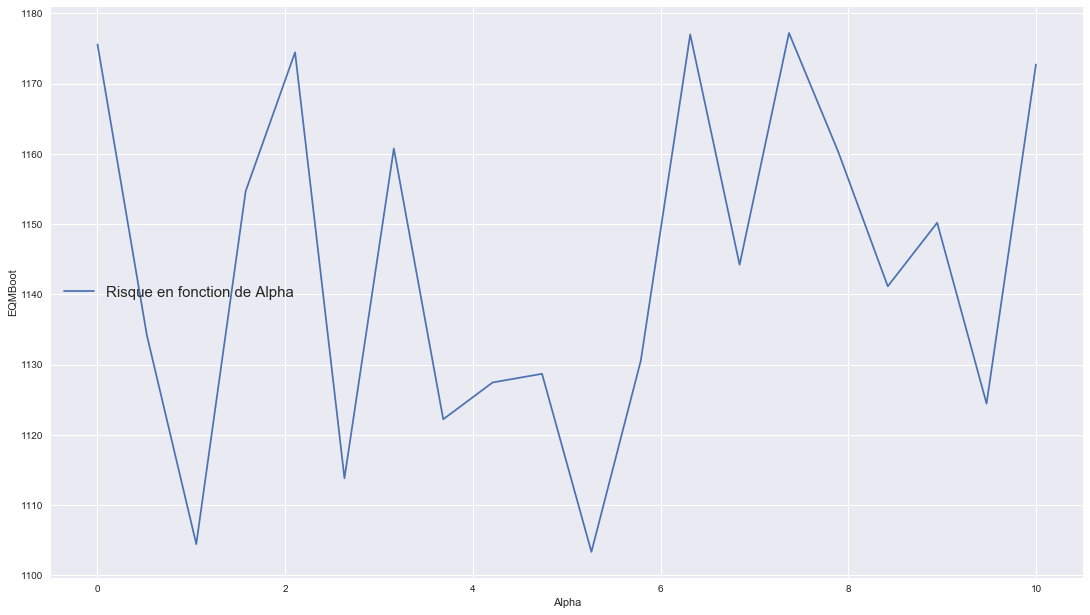

In [18]:
print("le résultat est: \n", AlphaGridDiabetes_2)
plt.style.use('seaborn')
plt.figure(figsize=(18.5, 10.5))
plt.plot(alphagridiabetes_2, AlphaGridDiabetes_2,
         label="Risque en fonction de Alpha")
plt.legend(fontsize=15, loc=6)
plt.xlabel("Alpha")
plt.ylabel("EQMBoot")
plt.show()

## 2 eme Partie

In [4]:
# import des données
import statsmodels.datasets as sd
data = sd.get_rdataset('airquality').data
df = pd.DataFrame(data)
df.head()

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41.0,190.0,7.4,67,5,1
1,36.0,118.0,8.0,72,5,2
2,12.0,149.0,12.6,74,5,3
3,18.0,313.0,11.5,62,5,4
4,NaN,NaN,14.3,56,5,5


In [5]:
# on regarde ou sont localisés les valeurs nulles
df.isnull().sum()
df_clean = df.dropna()
df_clean.isnull().sum()

Ozone      0
Solar.R    0
Wind       0
Temp       0
Month      0
Day        0
dtype: int64

## Question 9

In [6]:
Y = df_clean['Ozone']
X = pr.scale(df_clean.loc[:, df_clean.columns != 'Ozone'])
np.zeros([X.shape[1], ]).shape

(5,)

## Question 10

In [7]:
from sklearn.base import RegressorMixin
from sklearn.linear_model.base import LinearRegression


def stpforward(X, y, M):
    selected_variables = []
    residual = y
    p = X.shape[1]
    coef_selected = np.zeros(p)
    for i in range(1, M + 1):
        tab_alphaj = np.zeros(p)
        for j in range(0, p):
            if (j not in selected_variables):
                Xj = X[:, j]
                valeur_alphaj = np.abs(Xj.dot(residual))
                tab_alphaj[j] = valeur_alphaj
        jmax = np.argmax(tab_alphaj)
        selected_variables.append(jmax)
        X_selected = X[:, selected_variables]
        skl_linmod = linear_model.LinearRegression(fit_intercept=True)
        skl_linmod.fit(X_selected, y)
        coef_selected[selected_variables] = skl_linmod.coef_
        residual = y - skl_linmod.predict(X_selected)
    return coef_selected, selected_variables

# Test
stpforward(X, Y, 6)

(array([  2.28096538, -11.75277084,  17.98521995,  -4.45895297,   2.37393859]),
 [2, 1, 0, 3, 4, 0])

## Question 11 et 12

In [8]:
class MYOMP(LinearRegression, RegressorMixin):

    def __init__(self, n_nonzero_coefs=None, fit_intercept=False,
                 normalize=False, precompute='auto'):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.precompute = precompute
        self.n_nonzero_coefs = n_nonzero_coefs
        self.LinearRegression = LinearRegression(
            fit_intercept=self.fit_intercept)

    def stpforward(X, y, M):
        selected_variables = []
        residual = y
        p = X.shape[1]
        coef_selected = np.zeros(p)
        for i in range(1, M + 1):
            tab_alphaj = np.zeros(p)
            for j in range(0, p):
                if (j not in selected_variables):
                    Xj = X[:, j]
                    valeur_alphaj = np.abs(Xj.dot(residual))
                    tab_alphaj[j] = valeur_alphaj
            jmax = np.argmax(tab_alphaj)
            selected_variables.append(jmax)
            X_selected = X[:, selected_variables]
            skl_linmod = self.LinearModel()
            skl_linmod.fit(X_selected, y)
            coef_selected[selected_variables] = skl_linmod.coef_
            residual = y - skl_linmod.predict(X_selected)
        return coef_selected, selected_variables

    def fit(self, X, Y):
        i = 0
        self.selected_variables = []
        self.coef_ = np.zeros([X.shape[1], len(self.n_nonzero_coefs)])
        if self.normalize:
            X = pr.scale[X]
        if len(self.n_nonzero_coefs) == 0:
            self.n_nonzero_coefs = 0.1 * X.shape[1]
        for nonz in self.n_nonzero_coefs:
            tmp = stpforward(X, Y, nonz)
            self.selected_variables.append(tmp[1])
            self.coef_[:, i] = tmp[0]
            i += 1
        return self

myomp = MYOMP(LinearRegression, RegressorMixin)
myomp.n_nonzero_coefs = np.arange(1, 6)
print(myomp.n_nonzero_coefs)
myomp.fit(X, Y)
print("Ma matrice de coefficient est \n", myomp.coef_)
print("Ma liste d'indices selectionnés est \n", myomp.selected_variables)

[1 2 3 4 5]
Ma matrice de coefficient est 
 [[  0.           0.           5.42816683   4.50045463   4.56193076]
 [  0.         -11.66917173 -11.80641781 -11.74591966 -11.75277084]
 [ 23.13969957  17.33790739  15.67331326  17.7488752   17.98521995]
 [  0.           0.           0.          -4.38806519  -4.45895297]
 [  0.           0.           0.           0.           2.37393859]]
Ma liste d'indices selectionnés est 
 [[2], [2, 1], [2, 1, 0], [2, 1, 0, 3], [2, 1, 0, 3, 4]]


## Question 13

In [9]:
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV

n_nonzero_coefs = np.arange(1, 6)
coef_ = np.zeros([X.shape[1], len(n_nonzero_coefs)])
idx = []
i = 0
j = 0
res = []

for x in n_nonzero_coefs:
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=x)
    omp.fit(X, Y)
    coef = omp.coef_
    idx_r, = coef.nonzero()
    idx.append(idx_r,)
    coef_[:, i] = coef
    i += 1

print(myomp.selected_variables)
print(idx)

for x, x1 in zip(idx, myomp.selected_variables):
    res.append(np.isclose(x, x1))
    j += 1

print("On a égalités des coefficients avec les coefficients de MYOMP : ",
      np.isclose(coef_, myomp.coef_))
print("On a pas égalités sur l'ordre des indices selectionnes avec ceux de MYOMP : ",
      res)

[[2], [2, 1], [2, 1, 0], [2, 1, 0, 3], [2, 1, 0, 3, 4]]
[array([2]), array([1, 2]), array([0, 1, 2]), array([0, 1, 2, 3]), array([0, 1, 2, 3, 4])]
On a égalités des coefficients avec les coefficients de MYOMP :  [[ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]
On a pas égalités sur l'ordre des indices selectionnes avec ceux de MYOMP :  [array([ True], dtype=bool), array([False, False], dtype=bool), array([False,  True, False], dtype=bool), array([False,  True, False,  True], dtype=bool), array([False,  True, False,  True,  True], dtype=bool)]


## 14 eme question


In [11]:
from sklearn.model_selection import GridSearchCV


# Set the parameters by cross-validation
tuned_parameters = [{'n_nonzero_coefs': [1, 2, 3, 4, 5]}]

clf = GridSearchCV(OrthogonalMatchingPursuit(), tuned_parameters, cv=3, scoring ='neg_mean_squared_error')
clf.fit(X, Y)
# print(clf.best_params_)
print(sorted(clf.cv_results_.keys()))
# print(clf.cv_results_)
# nombre de parametres à garder
print('nombre de parametres à garder \n',
      clf.cv_results_['rank_test_score'][0])

['mean_fit_time', 'mean_score_time', 'mean_test_score', 'mean_train_score', 'param_n_nonzero_coefs', 'params', 'rank_test_score', 'split0_test_score', 'split0_train_score', 'split1_test_score', 'split1_train_score', 'split2_test_score', 'split2_train_score', 'std_fit_time', 'std_score_time', 'std_test_score', 'std_train_score']
nombre de parametres à garder 
 5


## 15 eme question

[5 4 2 3 1]
[-692.27599253 -556.31448192 -525.67845218 -526.06546146 -490.36280688]


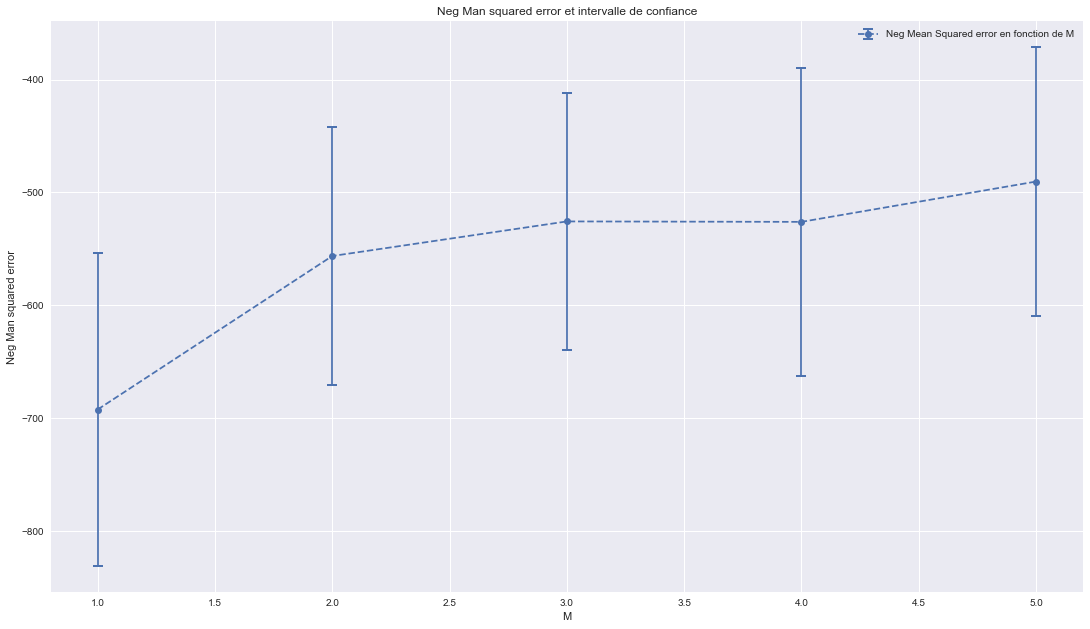

In [24]:
# std_test_score
print(clf.cv_results_['rank_test_score'])
print(clf.cv_results_['mean_test_score'])
plt.style.use('seaborn')
plt.figure(figsize=(18.5, 10.5))
plt.errorbar(np.arange(1, 6), clf.cv_results_[
    'mean_test_score'], yerr=clf.cv_results_['std_test_score'], fmt='--o',
    capsize=5, capthick=2, label="Neg Mean Squared error en fonction de M")
plt.legend(fontsize=15, loc=9)
plt.xlabel("M")
plt.ylabel("Neg Man squared error")
plt.title("Neg Man squared error et intervalle de confiance")
plt.legend()
plt.show()

On remarque que le score est d'après la documentation : est 'neg_mean_squared_error' Le meilleur score possible est donc 0. La valeur maximum est atteinte pour M=5 et vaut -490.36280688

In [25]:
print("l'intervalle de confiance pour la valeur optimale est +-: ",
      clf.cv_results_['std_test_score'][4])

l'intervalle de confiance pour la valeur optimale est +-:  119.198975854


Ce qui compte tenu de a valeur du score de M est un intervalle assez large car elle est égale à un peu 25 % de cette derniere.(-490 vs 120)